In [1]:
# !pip install datasets

In [2]:
# # given starter code to load and visualize emoji dataset



# import os
# import numpy as np
# from PIL import Image
# import matplotlib.pyplot as plt
# from textwrap import wrap
# from datasets import load_dataset

# mydata = load_dataset('valhalla/emoji-dataset')
# keywords = ['face','christmas','superhero','supervillian','mage','vampire','monkey','elf','juggling',
#             'boy','girl','adult','person','man','woman','male','female','worker','scientist','technologist',
#             'singer','artist','pilot','astronaut','firefighter','police','sleuth','construction']


# plt.rcParams["figure.figsize"] = [1.5, 1.50]

# mydata = load_dataset('valhalla/emoji-dataset')
# print(len(mydata['train']))
# total_obs = len(mydata['train'])
# data = np.zeros([total_obs,3,64,64],dtype='float32')
# for i in range(total_obs):
#     print(i)
#     im = mydata['train'][i]['image']
#     title = mydata['train'][i]['text']
#     if title.find(keywords[0]) > -1:
#         plt.imshow(im)
#         print(title)
#         plt.show()

#         im = im.resize((64,64),Image.LANCZOS)
#         title = "lower resolution"
#         plt.imshow(im)
#         print(title)
#         plt.show()
#         pix = im.load()
#         for x in range(im.size[0]):
#             for y in range(im.size[1]):
#                 for c in range(3):
#                     data[i,c,x,y] = float(pix[x,y][c]) / 255.0


## part 1

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.transforms.functional import to_tensor

from datasets import load_dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import os 


print(f"PyTorch Version: {torch.__version__}")

PyTorch Version: 2.1.1


## settings and loading data

In [4]:

SEED = 42
IMG_SIZE = 64
LATENT_DIM = 1024
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 1e-3
DATA_SUBSET_KEY = "face"

TARGET_TRAIN_SIZE = 600
TARGET_VAL_SIZE = 200
TARGET_TEST_SIZE = 200

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [5]:

preprocess = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE), interpolation=T.InterpolationMode.LANCZOS),  
    T.ToTensor(),
])


augment = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE), interpolation=T.InterpolationMode.LANCZOS), 
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    T.ToTensor(),
])

In [6]:
class EmojiDataset(Dataset):
    def __init__(self, hf_dataset, transform, target_size=None):
        self.hf_dataset = hf_dataset
        self.transform = transform
        self.original_size = len(hf_dataset)
        self.target_size = target_size if target_size is not None else self.original_size

    def __len__(self):
        return self.target_size

    def __getitem__(self, idx):
        original_idx = idx % self.original_size

        image = self.hf_dataset[original_idx]['image'].convert("RGB")

        tensor_image = self.transform(image)

        return tensor_image, tensor_image

In [7]:

print("Loading dataset...")
full_dataset = load_dataset("valhalla/emoji-dataset")['train']

subset_dataset = full_dataset.filter(lambda x: DATA_SUBSET_KEY in x['text'].lower())
print(f"Found {len(subset_dataset)} images with keyword '{DATA_SUBSET_KEY}'.")

train_val_split = subset_dataset.train_test_split(test_size=0.4, seed=SEED)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=SEED) # 0.4 * 0.5 = 0.2

hf_train = train_val_split['train']
hf_val = val_test_split['train']
hf_test = val_test_split['test']

print(f"Original splits: Train: {len(hf_train)}, Val: {len(hf_val)}, Test: {len(hf_test)}")

train_dataset = EmojiDataset(hf_train, transform=augment, target_size=TARGET_TRAIN_SIZE)
val_dataset = EmojiDataset(hf_val, transform=preprocess, target_size=TARGET_VAL_SIZE)
test_dataset = EmojiDataset(hf_test, transform=preprocess, target_size=TARGET_TEST_SIZE)

print(f"Augmented splits: Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("DataLoaders created.")

Loading dataset...
Found 204 images with keyword 'face'.
Original splits: Train: 122, Val: 41, Test: 41
Augmented splits: Train: 600, Val: 200, Test: 200
DataLoaders created.


Displaying sample augmented training images...


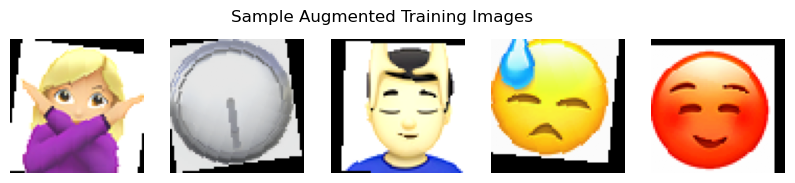

In [8]:

def imshow(tensor, title=None):
    image = tensor.cpu().permute(1, 2, 0).numpy() # [C, H, W] -> [H, W, C]
    image = np.clip(image, 0, 1) 
    plt.imshow(image)
    plt.axis('off')
    if title:
        plt.title(title)

print("Displaying sample augmented training images...")
sample_images, _ = next(iter(train_loader))
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    imshow(sample_images[i])
plt.suptitle("Sample Augmented Training Images ")
plt.show()

## implement and train auto encoder

In [9]:
import torch.nn.functional as F

class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvAutoencoder, self).__init__()
        
        self.encoder_cnn = nn.Sequential(
            # (B, 3, 64, 64) -> (B, 32, 32, 32)
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (B, 32, 32, 32) -> (B, 64, 16, 16)
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (B, 64, 16, 16) -> (B, 128, 8, 8)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        

        self.flatten = nn.Flatten()

        self.encoder_fc = nn.Linear(128 * 8 * 8, latent_dim)

        self.decoder_fc = nn.Linear(latent_dim, 128 * 8 * 8)

        self.unflatten = nn.Unflatten(1, (128, 8, 8)) # (B, 128, 8, 8)
        
        self.decoder_cnn = nn.Sequential(
            # (B, 128, 8, 8) -> (B, 64, 16, 16)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (B, 64, 16, 16) -> (B, 32, 32, 32)
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (B, 32, 32, 32) -> (B, 3, 64, 64)
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),

            nn.Sigmoid()
        )

    def forward(self, x):
        x_cnn = self.encoder_cnn(x)
        x_flat = self.flatten(x_cnn)
        latent = self.encoder_fc(x_flat) 

        x_unflat = self.decoder_fc(latent)
        x_unflat_img = self.unflatten(x_unflat)
        reconstructed = self.decoder_cnn(x_unflat_img)
        
        return reconstructed


model = ConvAutoencoder(latent_dim=LATENT_DIM).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("--- new model arch ---")
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_params:,}")

--- new model arch ---
ConvAutoencoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_fc): Linear(in_features=8192, out_features=1024, bias=True)
  (decoder_fc): Linear(in_features=1024, out_features=8192, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(128, 8, 8))
  (decoder_cnn): Sequenti

In [10]:
# training loop

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    
    print(f"Starting training for {epochs} epochs...")

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        
        for inputs, targets in train_pbar:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * inputs.size(0)
            train_pbar.set_postfix({'loss': loss.item()})
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
        
        with torch.no_grad():
            for inputs, targets in val_pbar:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item() * inputs.size(0)
                val_pbar.set_postfix({'loss': loss.item()})
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        # print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), "autoencoder_best_weights.pth")
            
    print("Training finished.")
    print(f"Best validation loss: {best_val_loss:.6f}")
    print("Best model weights saved to autoencoder_best_weights.pth")
    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS)

print("Loading best model weights for evaluation...")
model.load_state_dict(torch.load("autoencoder_best_weights.pth"))

Starting training for 100 epochs...


Training finished.
Best validation loss: 0.011022
Best model weights saved to autoencoder_best_weights.pth
Loading best model weights for evaluation...


<All keys matched successfully>

1a. I used Huggingface valhalla/emoji-dataset and chose 'face' keyword. I followed 60/20/20 ratio to split into train val test, and used ColorJitter、HorizontalFlip and Affine, to augment the data. 

images are scaled to 64x 64 x 3 and normalized into [0, 1]

1b. My architecture is a convolutional autoencoder. The encoder has three Conv2d layers with batchnorm and LeakyReLU, reducing spatial size from 64x64 to 8x8 and increasing channels. A linear layer then compresses the flattened features to a 1024 latent dimension. The decoder mirrors this with a linear layer and three ConvTranspose2d layers, also with batchnorm and LeakyReLU, to reconstruct the 64x64x3 image. The final layer uses a Sigmoid activation.

1c. The 1024 latent dimension was selected to give the model enough capacity to capture detailed facial features for accurate reconstruction. I used LeakyReLU to prevent dying neurons and a Sigmoid output to match the [0, 1] normalized data. MSELoss was used for pixel-wise reconstruction, as the required. BatchNorm2d was added after each conv layer to stabilize and accelerate training.

1d. My hyperparameters were: 64x64 image size, 1024 latent dimension, Adam optimizer, 1e-3 learning rate, 32 batch size, 100 epochs, and MSE loss.

1e: see below.

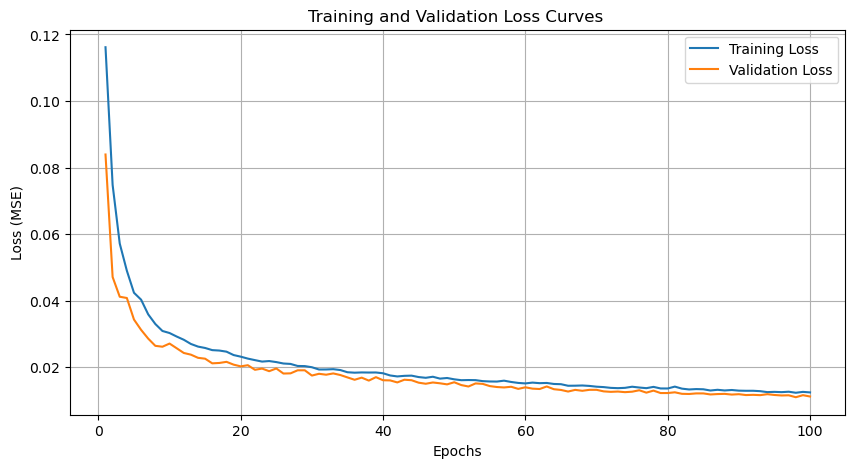

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Curves ')
plt.legend()
plt.grid(True)
plt.show()

最终测试集错误 
我们在保留的测试集上评估模型的最终性能。

In [12]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_test_loss = 0.0
    
    test_pbar = tqdm(test_loader, desc="Evaluating on Test Set", leave=False)
    
    with torch.no_grad():
        for inputs, targets in test_pbar:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_test_loss += loss.item() * inputs.size(0)
    
    test_loss = running_test_loss / len(test_loader.dataset)
    return test_loss

final_test_error = evaluate_model(model, test_loader, criterion)
print(f"\nFinal Average Error (MSE) on Test Set: {final_test_error:.6f} ")


Final Average Error (MSE) on Test Set: 0.011388 


1f. 0.011388, as printed above.

1g. see below.

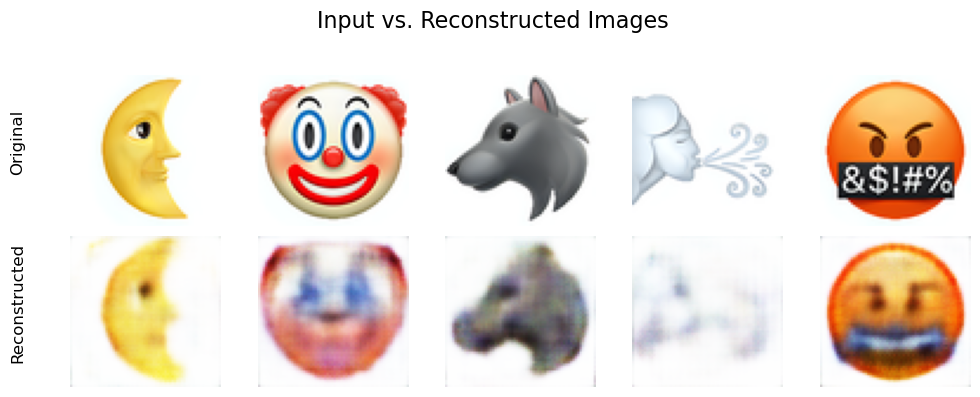

In [13]:
def show_reconstructions(model, test_loader, n=5):
    model.eval()
    inputs, _ = next(iter(test_loader)) 
    inputs = inputs.to(DEVICE)
    
    with torch.no_grad():
        outputs = model(inputs)
    
    inputs = inputs.cpu()
    outputs = outputs.cpu()
    
    plt.figure(figsize=(10, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        imshow(inputs[i])
        if i == 0:
            ax.set_title("Original", loc='left', y=0.5, x=-0.3, rotation=90, va='center', ha='right', fontsize=12)

        ax = plt.subplot(2, n, i + 1 + n)
        imshow(outputs[i])
        if i == 0:
            ax.set_title("Reconstructed", loc='left', y=0.5, x=-0.3, rotation=90, va='center', ha='right', fontsize=12)
            
    plt.suptitle("Input vs. Reconstructed Images ", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

show_reconstructions(model, test_loader, n=5)

1h. the learning curve looks just fine, but these images are not satisfactory enough. They are vague.

** Part 2 **

In [14]:

def find_image_by_text(dataset, text_query):
    for item in dataset:
        if text_query.lower() in item['text'].lower():
            return item['image'].convert("RGB")
    return None

def get_latent_vector(model, image_text, dataset, transform):
    image = find_image_by_text(dataset, image_text)
    if image is None:
        raise ValueError(f"Image '{image_text}' not found in dataset.")

    tensor_image = transform(image).unsqueeze(0).to(DEVICE) # (1, C, H, W)
    
    model.eval()
    with torch.no_grad():
        x_cnn = model.encoder_cnn(tensor_image)
        x_flat = model.flatten(x_cnn)
        latent = model.encoder_fc(x_flat) 
        
    return latent, image

def decode_latent_vector(model, latent):
    model.eval()
    with torch.no_grad():
        x_unflat = model.decoder_fc(latent)
        x_unflat_img = model.unflatten(x_unflat)
        reconstructed = model.decoder_cnn(x_unflat_img)
        
    return reconstructed.squeeze(0).cpu() # (C, H, W)

print("Helper functions (get_latent_vector, decode_latent_vector) updated.")

Helper functions (get_latent_vector, decode_latent_vector) updated.


2a. I followed the adviced config in the pdf and selected the 'glasses' attribute from the 'Nerd Face' emoji. The vector arithmetic applied was: Generated = Tongue + (Nerd - Smile). This was implemented by taking the latent vectors (z) of 'Face with Stuck Out Tongue' (z_tongue), 'Nerd Face' (z_nerd), and 'Smiling Face With Open Mouth' (z_smile), and calculating z_generated = z_tongue + (z_nerd - z_smile). Then pass the resulting latent vector to the decoder.

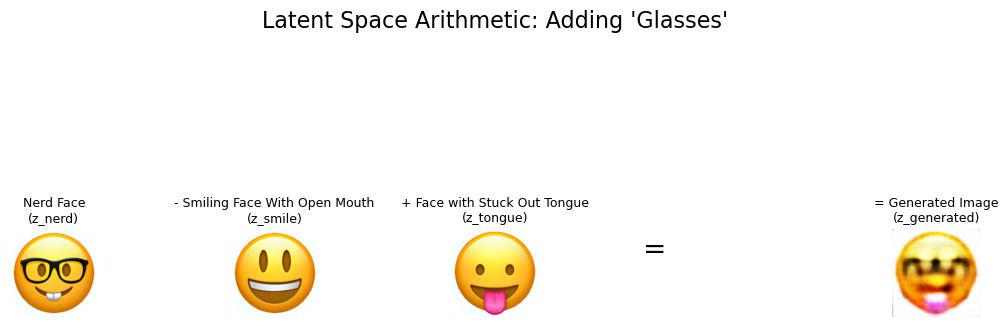

Latent vectors saved to latent_vectors.pth


In [15]:

IMG_NERD = "Nerd Face"
IMG_SMILE = "Smiling Face With Open Mouth"
IMG_TONGUE = "Face with Stuck Out Tongue"

z_nerd, img_nerd = get_latent_vector(model, IMG_NERD, full_dataset, preprocess)
z_smile, img_smile = get_latent_vector(model, IMG_SMILE, full_dataset, preprocess)
z_tongue, img_tongue = get_latent_vector(model, IMG_TONGUE, full_dataset, preprocess)

z_generated = z_tongue + (z_nerd - z_smile)

img_generated_tensor = decode_latent_vector(model, z_generated)

plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 5, 1)
ax.imshow(img_nerd)
ax.set_title(f"{IMG_NERD}\n(z_nerd)", fontsize=9) 
ax.axis('off')

ax = plt.subplot(1, 5, 2)
ax.imshow(img_smile)
ax.set_title(f"- {IMG_SMILE}\n(z_smile)", fontsize=9)
ax.axis('off')

ax = plt.subplot(1, 5, 3)
ax.imshow(img_tongue)
ax.set_title(f"+ {IMG_TONGUE}\n(z_tongue)", fontsize=9)
ax.axis('off')

ax = plt.subplot(1, 5, 5)
imshow(img_generated_tensor)
ax.set_title(f"= Generated Image\n(z_generated)", fontsize=9)
ax.axis('off')

plt.text(0.66, 0.5, '=', fontsize=20, ha='center', va='center', transform=plt.gcf().transFigure)

plt.suptitle("Latent Space Arithmetic: Adding 'Glasses'", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

latent_vectors_dict = {
    'z_nerd': z_nerd.cpu(),
    'z_smile': z_smile.cpu(),
    'z_tongue': z_tongue.cpu(),
    'z_generated': z_generated.cpu()
}
torch.save(latent_vectors_dict, "latent_vectors.pth")
print("Latent vectors saved to latent_vectors.pth")


2b. The composite image is OK but not 100% successful. The generated image shows a 'Face with Stuck Out Tongue' that is now wearing the 'glasses' from the 'Nerd Face', but is vague and less clear than the demo in the pdf file. The operation to some extent successfully isolated the 'glasses' attribute (z_nerd - z_smile) and applied it to the new base image.

2c. The quality of the generated image could be improved. It appears slightly blurrier than the original inputs, which is a common artifact of MSE-based autoencoders. maybe we can use a different loss function that prioritizes perceptual similarity (like LPIPS) instead of just pixel-wise error. A more advanced model, like a Variational Autoencoder (VAE) or a Generative Adversarial Network (GAN), might also produce sharper and more realistic results.

I implemented the VAE below, but it seems like the qualit is still not very impressive.

In [23]:

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.flatten = nn.Flatten()

        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_log_var = nn.Linear(128 * 8 * 8, latent_dim)

        self.decoder_fc = nn.Linear(latent_dim, 128 * 8 * 8)
        self.unflatten = nn.Unflatten(1, (128, 8, 8))
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x_cnn = self.encoder_cnn(x)
        x_flat = self.flatten(x_cnn)
        
        mu = self.fc_mu(x_flat)
        log_var = self.fc_log_var(x_flat)

        z = self.reparameterize(mu, log_var)

        x_unflat = self.decoder_fc(z)
        x_unflat_img = self.unflatten(x_unflat)
        reconstructed = self.decoder_cnn(x_unflat_img)

        return reconstructed, mu, log_var

print("VAE Model Class Defined.")

VAE Model Class Defined.


In [24]:

def vae_loss_function(reconstructed, x, mu, log_var):
    recon_loss = F.mse_loss(reconstructed, x, reduction='sum')

    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    KLD_WEIGHT = 0.00025
    
    return recon_loss + KLD_WEIGHT * kld_loss, recon_loss, kld_loss

def train_vae_model(model, train_loader, val_loader, optimizer, epochs):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    print(f"Starting VAE training for {epochs} epochs...")

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        
        for inputs, targets in train_pbar:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            
            optimizer.zero_grad()
            outputs, mu, log_var = model(inputs)
            
            loss, recon, kld = vae_loss_function(outputs, targets, mu, log_var)
            
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * inputs.size(0)
            train_pbar.set_postfix({'loss': loss.item() / inputs.size(0), 
                                  'recon': recon.item() / inputs.size(0), 
                                  'kld': kld.item() / inputs.size(0)})
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
        
        with torch.no_grad():
            for inputs, targets in val_pbar:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs, mu, log_var = model(inputs)
                loss, _, _ = vae_loss_function(outputs, targets, mu, log_var)
                running_val_loss += loss.item() * inputs.size(0)
                val_pbar.set_postfix({'loss': loss.item() / inputs.size(0)})
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        # print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.2f} | Val Loss: {epoch_val_loss:.2f}")
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), "vae_best_weights.pth")
            
    print("VAE Training finished.")
    print(f"Best validation loss: {best_val_loss:.2f}")
    print("Best VAE model weights saved to vae_best_weights.pth")
    return train_losses, val_losses

print("VAE training loop and loss function defined.")

VAE training loop and loss function defined.


In [25]:

vae_model = VAE(latent_dim=LATENT_DIM).to(DEVICE)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=LEARNING_RATE)

print("--- VAE arch ---")
print(vae_model)
total_params = sum(p.numel() for p in vae_model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_params:,}")

vae_train_losses, vae_val_losses = train_vae_model(vae_model, train_loader, val_loader, vae_optimizer, epochs=EPOCHS)

print("Loading best VAE model weights for evaluation...")
vae_model.load_state_dict(torch.load("vae_best_weights.pth"))

--- VAE arch ---
VAE(
  (encoder_cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_mu): Linear(in_features=8192, out_features=1024, bias=True)
  (fc_log_var): Linear(in_features=8192, out_features=1024, bias=True)
  (decoder_fc): Linear(in_features=1024, out_features=8192, bias=True)
  (unflatten): Unflatten(dim=1, unflatt

VAE Training finished.
Best validation loss: 4814.72
Best VAE model weights saved to vae_best_weights.pth
Loading best VAE model weights for evaluation...


<All keys matched successfully>

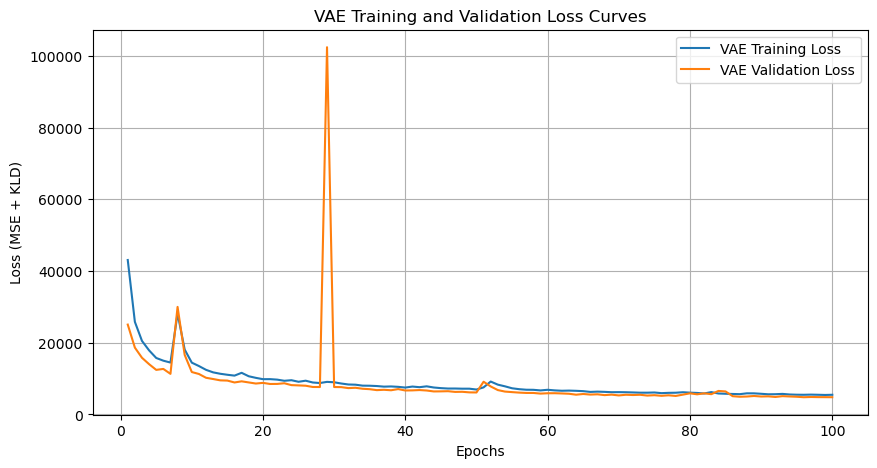

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), vae_train_losses, label='VAE Training Loss')
plt.plot(range(1, EPOCHS + 1), vae_val_losses, label='VAE Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE + KLD)')
plt.title('VAE Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

--- VAE eval ---


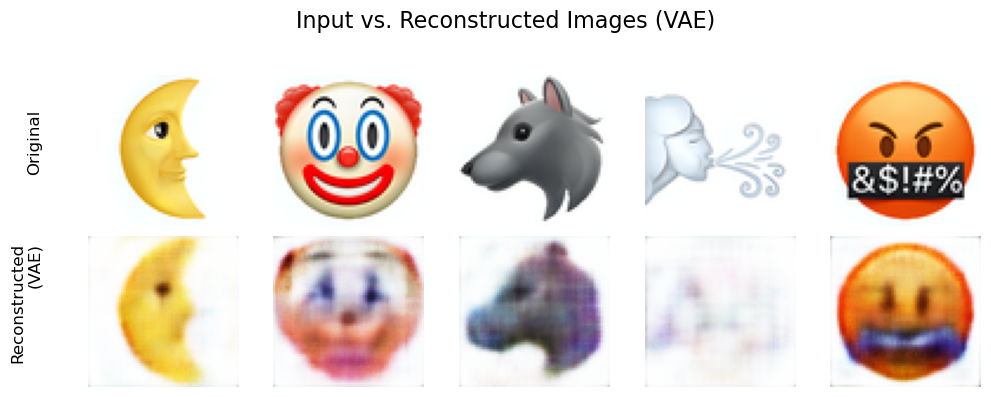

In [27]:

def show_vae_reconstructions(model, test_loader, n=5):
    model.eval()
    inputs, _ = next(iter(test_loader))
    inputs = inputs.to(DEVICE)
    
    with torch.no_grad():
        outputs, _, _ = model(inputs) 
    
    inputs = inputs.cpu()
    outputs = outputs.cpu()
    
    plt.figure(figsize=(10, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        imshow(inputs[i])
        if i == 0:
            ax.set_title("Original", loc='left', y=0.5, x=-0.3, rotation=90, va='center', ha='right', fontsize=12)
        
        ax = plt.subplot(2, n, i + 1 + n)
        imshow(outputs[i])
        if i == 0:
            ax.set_title("Reconstructed\n(VAE)", loc='left', y=0.5, x=-0.3, rotation=90, va='center', ha='right', fontsize=12)
            
    plt.suptitle("Input vs. Reconstructed Images (VAE)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

print("--- VAE eval ---")
show_vae_reconstructions(vae_model, test_loader, n=5)

In [28]:


def get_latent_vector_vae(model, image_text, dataset, transform):

    image = find_image_by_text(dataset, image_text)
    if image is None:
        raise ValueError(f"Image '{image_text}' not found in dataset.")
    
    tensor_image = transform(image).unsqueeze(0).to(DEVICE)
    
    model.eval()
    with torch.no_grad():
        _, mu, _ = model(tensor_image)
        
    return mu, image

# print("VAE helper function 'get_latent_vector_vae' defined.")

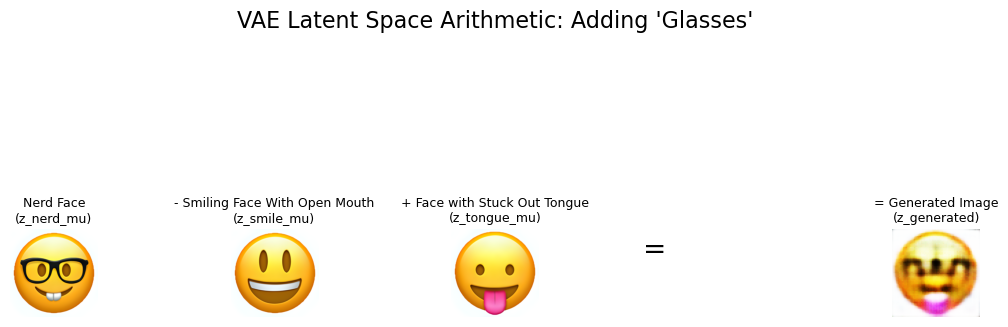

VAE latent vectors (mu) saved to vae_latent_vectors.pth


In [29]:

IMG_NERD = "Nerd Face"
IMG_SMILE = "Smiling Face With Open Mouth"
IMG_TONGUE = "Face with Stuck Out Tongue"

z_nerd_mu, img_nerd = get_latent_vector_vae(vae_model, IMG_NERD, full_dataset, preprocess)
z_smile_mu, img_smile = get_latent_vector_vae(vae_model, IMG_SMILE, full_dataset, preprocess)
z_tongue_mu, img_tongue = get_latent_vector_vae(vae_model, IMG_TONGUE, full_dataset, preprocess)

z_generated = z_tongue_mu + (z_nerd_mu - z_smile_mu)

img_generated_tensor = decode_latent_vector(vae_model, z_generated)

plt.figure(figsize=(10, 5))

ax = plt.subplot(1, 5, 1)
ax.imshow(img_nerd)
ax.set_title(f"{IMG_NERD}\n(z_nerd_mu)", fontsize=9)
ax.axis('off')

ax = plt.subplot(1, 5, 2)
ax.imshow(img_smile)
ax.set_title(f"- {IMG_SMILE}\n(z_smile_mu)", fontsize=9)
ax.axis('off')

ax = plt.subplot(1, 5, 3)
ax.imshow(img_tongue)
ax.set_title(f"+ {IMG_TONGUE}\n(z_tongue_mu)", fontsize=9)
ax.axis('off')

ax = plt.subplot(1, 5, 5)
imshow(img_generated_tensor)
ax.set_title(f"= Generated Image\n(z_generated)", fontsize=9)
ax.axis('off')

plt.text(0.66, 0.5, '=', fontsize=20, ha='center', va='center', transform=plt.gcf().transFigure)
plt.suptitle("VAE Latent Space Arithmetic: Adding 'Glasses'", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

latent_vectors_dict = {
    'z_nerd': z_nerd_mu.cpu(),
    'z_smile': z_smile_mu.cpu(),
    'z_tongue': z_tongue_mu.cpu(),
    'z_generated': z_generated.cpu()
}
torch.save(latent_vectors_dict, "vae_latent_vectors.pth")
print("VAE latent vectors (mu) saved to vae_latent_vectors.pth")
